In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

category_dict = { "FYMILP": Folder_A,
                 "OPC":Folder_B,
                 "R&D": Folder_D ,
                 "OPT_LB": Folder_E,
                 "HI": Folder_K,
                  "CHI": Folder_L,
                }

#  Generation cost timeseries

In [17]:
def create_generation_cost_fyts_frame(CaseName_Base, cm, nbc):
    destination_folder = f"Y.FYTS_from_ByStages/{CaseName_Base}/{cm}"

    filename = f"Generation_cost_nc{nbc}.csv"

    # Read input data
    df_duration = pd.read_csv(
        f"{folder_name}/{CaseName_Base}_ByStages_nc{nbc}/2.Par/oT_Data_Duration_{CaseName_Base}_ByStages_nc{nbc}.csv")
    df_ts_bs = pd.read_csv(
        f"{folder_name}/{CaseName_Base}_ByStages_nc{nbc}/4.OutWoInv/oT_Result_GenerationCost_{CaseName_Base}_ByStages_nc{nbc}.csv")

    # Ensure data types are consistent: convert load levels to strings
    df_duration["LoadLevel"] = df_duration["LoadLevel"].astype(str)
    df_ts_bs["LoadLevel"] = df_ts_bs["LoadLevel"].astype(str)

    # Create mapping of load level to stage name
    load_level_stage_map = df_duration.set_index("LoadLevel")["Stage"].to_dict()
    all_load_levels = df_duration.LoadLevel

    # Create dataframe that that wil hold all timeseries
    frame_values = pd.DataFrame({"LoadLevel": all_load_levels})


    # Initialize the full-year time series array
    fy_ts = np.zeros(len(all_load_levels))

    # Create full-year time series based on mapping and values of representative load levels
    for i, load_level in enumerate(all_load_levels):
        this_loadlevel_stage = load_level_stage_map[load_level]

        # Filter to find the correct reduced load level
        filtered_duration = df_duration[
            (df_duration["Stage"] == this_loadlevel_stage) & (df_duration["Duration"] == 1)]
        nb_hours_represented = len(df_duration[(df_duration["Stage"] == this_loadlevel_stage)])
#         print(nb_hours_represented)

        if not filtered_duration.empty:
            reduced_temp_load_level = filtered_duration.LoadLevel.iloc[0]

            # Find the corresponding value in df_ts_bs
            reduced_temp_value = df_ts_bs[df_ts_bs["LoadLevel"] == str(reduced_temp_load_level)]

            if not reduced_temp_value.empty:
                # Assuming you want to assign a value from reduced_temp_value to fy_ts
                # You might need to aggregate if there are multiple values
                fy_ts[i] = reduced_temp_value['mEUR'].iloc[0]/nb_hours_represented  # Replace 'YourValueColumn' with the actual column name
        frame_values["mEUR"] = fy_ts
    return frame_values, destination_folder, filename

In [19]:
#Define case 
CaseName_Base = 'RTS24_mod1'


cm = "CHI"
folder_name = category_dict[cm]

nbcs = [20]

for nbc in nbcs:
    frame_values,destination_folder,filename = create_generation_cost_fyts_frame(CaseName_Base,cm,nbc)
    # Check if the destination folder exists, if not, create it
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    #And write dataframe to destination
    frame_values.to_csv(os.path.join(destination_folder,filename))

## Curtailment timeseries 

In [3]:
def create_curtailment_fyts_frame(CaseName_Base,cm,nbc): 
    
    destination_folder = f"Y.FYTS_from_ByStages/{CaseName_Base}/{cm}"

    filename = f"Curtailment_nc{nbc}.csv"


    # Read input data
    df_duration = pd.read_csv(f"{folder_name}/{CaseName_Base}_ByStages_nc{nbc}/2.Par/oT_Data_Duration_{CaseName_Base}_ByStages_nc{nbc}.csv")
    df_ts_bs = pd.read_csv(f"{folder_name}/{CaseName_Base}_ByStages_nc{nbc}/4.OutWoInv/oT_Result_RESCurtailment_{CaseName_Base}_ByStages_nc{nbc}.csv")

    # Ensure data types are consistent: convert load levels to strings
    df_duration["LoadLevel"] = df_duration["LoadLevel"].astype(str)
    df_ts_bs["LoadLevel"] = df_ts_bs["LoadLevel"].astype(str)
    df_ts_bs["Unit"] = df_ts_bs["Unit"].astype(str)

    # Create mapping of load level to stage name
    load_level_stage_map = df_duration.set_index("LoadLevel")["Stage"].to_dict()
    all_load_levels = df_duration.LoadLevel

    #Create dataframe that that wil hold all timeseries
    frame_values = pd.DataFrame({"LoadLevel":all_load_levels})

    # Select a unit
    units = np.unique(df_ts_bs.Unit)

    for unit in units:

        # Initialize the full-year time series array
        fy_ts = np.zeros(len(all_load_levels))

        # Create full-year time series based on mapping and values of representative load levels
        for i, load_level in enumerate(all_load_levels):
            this_loadlevel_stage = load_level_stage_map[load_level]

            # Filter to find the correct reduced load level
            filtered_duration = df_duration[(df_duration["Stage"] == this_loadlevel_stage) & (df_duration["Duration"] == 1)]

            if not filtered_duration.empty:
                reduced_temp_load_level = filtered_duration.LoadLevel.iloc[0]

                # Find the corresponding value in df_ts_bs
                reduced_temp_value = df_ts_bs[(df_ts_bs["Unit"] == unit) & (df_ts_bs["LoadLevel"] == str(reduced_temp_load_level))]

                if not reduced_temp_value.empty:
                    # Assuming you want to assign a value from reduced_temp_value to fy_ts
                    # You might need to aggregate if there are multiple values
                    fy_ts[i] = reduced_temp_value['MW'].iloc[0]  # Replace 'YourValueColumn' with the actual column name
        frame_values[unit] = fy_ts
    return frame_values,destination_folder,filename

In [4]:
#Define case 
CaseName_Base = '9n_mod1'


cm = "HI"
folder_name = category_dict[cm]

nbcs = [20,50,100,200]

for nbc in nbcs:
    frame_values,destination_folder,filename = create_curtailment_fyts_frame(CaseName_Base,cm,nbc)
    # Check if the destination folder exists, if not, create it
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    #And write dataframe to destination
    frame_values.to_csv(os.path.join(destination_folder,filename))

FileNotFoundError: [Errno 2] No such file or directory: 'K.Investments_per_hour/9n_mod1_ByStages_nc20/4.OutWoInv/oT_Result_RESCurtailment_9n_mod1_ByStages_nc20.csv'

In [16]:
frame_values,destination_folder

('LoadLevel', '101_PV_1')

## Network utilization timeseries

In [ ]:
destination_folder = f"Y.FYTS_from_ByStages/{CaseName_Base}/{cm}"

filename = f"Curtailment_nc{nbc}.csv"


# Read input data
df_duration = pd.read_csv(f"{folder_name}/{CaseName_Base}_ByStages_nc{nbc}/2.Par/oT_Data_Duration_{CaseName_Base}_ByStages_nc{nbc}.csv")
df_ts_bs = pd.read_csv(f"{folder_name}/{CaseName_Base}_ByStages_nc{nbc}/4.OutWoInv/oT_Result_RESCurtailment_{CaseName_Base}_ByStages_nc{nbc}.csv")

# Ensure data types are consistent: convert load levels to strings
df_duration["LoadLevel"] = df_duration["LoadLevel"].astype(str)
df_ts_bs["LoadLevel"] = df_ts_bs["LoadLevel"].astype(str)
df_ts_bs["Unit"] = df_ts_bs["Unit"].astype(str)

# Create mapping of load level to stage name
load_level_stage_map = df_duration.set_index("LoadLevel")["Stage"].to_dict()
all_load_levels = df_duration.LoadLevel

#Create dataframe that that wil hold all timeseries
frame_values = pd.DataFrame({"LoadLevel":all_load_levels})

# Select a unit
units = np.unique(df_ts_bs.Unit)

for unit in units:

    # Initialize the full-year time series array
    fy_ts = np.zeros(len(all_load_levels))

    # Create full-year time series based on mapping and values of representative load levels
    for i, load_level in enumerate(all_load_levels):
        this_loadlevel_stage = load_level_stage_map[load_level]

        # Filter to find the correct reduced load level
        filtered_duration = df_duration[(df_duration["Stage"] == this_loadlevel_stage) & (df_duration["Duration"] == 1)]

        if not filtered_duration.empty:
            reduced_temp_load_level = filtered_duration.LoadLevel.iloc[0]

            # Find the corresponding value in df_ts_bs
            reduced_temp_value = df_ts_bs[(df_ts_bs["Unit"] == unit) & (df_ts_bs["LoadLevel"] == str(reduced_temp_load_level))]

            if not reduced_temp_value.empty:
                # Assuming you want to assign a value from reduced_temp_value to fy_ts
                # You might need to aggregate if there are multiple values
                fy_ts[i] = reduced_temp_value['MW'].iloc[0]  # Replace 'YourValueColumn' with the actual column name
    frame_values[unit] = fy_ts

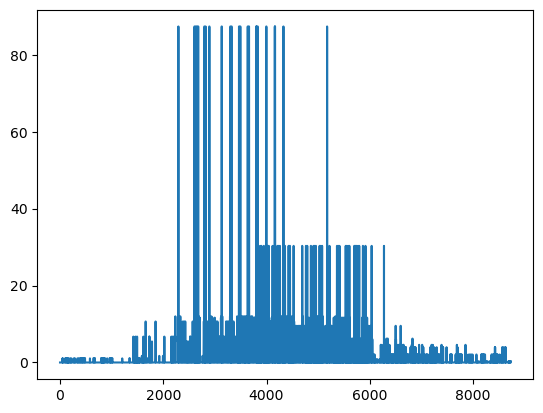

In [149]:
plt.plot(fy_ts)

In [123]:
reduced_temp_load_level

'10-30 21:00:00+01:00'

In [109]:
df_ts_bs[df_ts_bs["LoadLevel"] == str(reduced_temp_load_level)]

,Period,Scenario,LoadLevel,Unit,MW


In [111]:
df_ts_bs.LoadLevel.astype(str)

0      02-05 00:00:00+01:00
1      02-05 00:00:00+01:00
2      02-05 00:00:00+01:00
3      02-05 00:00:00+01:00
4      02-05 00:00:00+01:00
               ...         
205    12-20 14:00:00+01:00
206    12-20 14:00:00+01:00
207    12-20 14:00:00+01:00
208    12-20 14:00:00+01:00
209    12-20 14:00:00+01:00
Name: LoadLevel, Length: 210, dtype: object

In [75]:
df_duration[(df_duration["Stage"] == this_loadlevel_stage) & (df_duration["Duration"] == 1)]["LoadLevel"]

1677    03-11 21:00:00+01:00
Name: LoadLevel, dtype: object

In [82]:
units = np.unique(df_ts_bs.Unit)
unit = units[0]

df_ts_bs[df_ts_bs["Unit"]==unit]

fy_ts = np.array(len(all_load_levels))
for i,load_level in enumerate(all_load_levels[:10]):
    this_loadlevel_stage = load_level_stage_map[load_level]
    reduced_temp_load_level = df_duration[(df_duration["Stage"] == this_loadlevel_stage) & (df_duration["Duration"] == 1)].LoadLevel.iloc[0]
    print(this_loadlevel_stage)
    print(reduced_temp_load_level)
    reduced_temp_value = df_ts_bs[(df_ts_bs["Unit"]==unit) & (df_ts_bs["LoadLevel"]==str(reduced_temp_load_level))]
    #this_unit_this_loadlevel_val = 
    #fy_ts[i] = df_ts_bs[df_ts_bs["Unit"]==unit]

sti3
03-11 21:00:00+01:00
sti3
03-11 21:00:00+01:00
sti3
03-11 21:00:00+01:00
sti3
03-11 21:00:00+01:00
sti3
03-11 21:00:00+01:00
sti3
03-11 21:00:00+01:00
sti3
03-11 21:00:00+01:00
sti5
01-21 14:00:00+01:00
sti5
01-21 14:00:00+01:00
sti5
01-21 14:00:00+01:00


In [85]:
df_ts_bs[(df_ts_bs["Unit"]==unit)]

,Period,Scenario,LoadLevel,Unit,MW
20,2030,sc01,02-05 00:00:00+01:00,101_PV_1,0.000000
41,2030,sc01,02-08 16:00:00+01:00,101_PV_1,0.000000
62,2030,sc01,03-29 00:00:00+01:00,101_PV_1,0.000000
83,2030,sc01,05-22 05:00:00+02:00,101_PV_1,0.000000
104,2030,sc01,06-15 04:00:00+02:00,101_PV_1,0.000000
125,2030,sc01,06-20 17:00:00+02:00,101_PV_1,0.000000
146,2030,sc01,07-15 13:00:00+02:00,101_PV_1,16.615815
167,2030,sc01,08-26 04:00:00+02:00,101_PV_1,0.000000
188,2030,sc01,11-16 08:00:00+01:00,101_PV_1,0.000000
209,2030,sc01,12-20 14:00:00+01:00,101_PV_1,0.000000


In [15]:
load_level_stage_map

{'01-01 00:00:00+01:00': 'sti3',
 '01-01 01:00:00+01:00': 'sti3',
 '01-01 02:00:00+01:00': 'sti3',
 '01-01 03:00:00+01:00': 'sti3',
 '01-01 04:00:00+01:00': 'sti3',
 '01-01 05:00:00+01:00': 'sti3',
 '01-01 06:00:00+01:00': 'sti3',
 '01-01 07:00:00+01:00': 'sti5',
 '01-01 08:00:00+01:00': 'sti5',
 '01-01 09:00:00+01:00': 'sti5',
 '01-01 10:00:00+01:00': 'sti5',
 '01-01 11:00:00+01:00': 'sti5',
 '01-01 12:00:00+01:00': 'sti5',
 '01-01 13:00:00+01:00': 'sti5',
 '01-01 14:00:00+01:00': 'sti5',
 '01-01 15:00:00+01:00': 'sti8',
 '01-01 16:00:00+01:00': 'sti8',
 '01-01 17:00:00+01:00': 'sti8',
 '01-01 18:00:00+01:00': 'sti8',
 '01-01 19:00:00+01:00': 'sti3',
 '01-01 20:00:00+01:00': 'sti3',
 '01-01 21:00:00+01:00': 'sti3',
 '01-01 22:00:00+01:00': 'sti3',
 '01-01 23:00:00+01:00': 'sti3',
 '01-02 00:00:00+01:00': 'sti3',
 '01-02 01:00:00+01:00': 'sti3',
 '01-02 02:00:00+01:00': 'sti3',
 '01-02 03:00:00+01:00': 'sti3',
 '01-02 04:00:00+01:00': 'sti3',
 '01-02 05:00:00+01:00': 'sti3',
 '01-02 06